# Задание 2: document analysis


## Создание датасета

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import os

In [2]:
def make_dataset():
    dataset = []
    text_dir, nontext_dir = './Text', './Nontext'

    for data_dir, label in [(text_dir, 1), (nontext_dir, 0)]:
        xml_files = []
        for filename in os.listdir(data_dir):
            if filename.endswith(".xml"):
                xml_files.append(filename)
        
        for xml_file in xml_files:
            with open(data_dir + "/" + xml_file) as f:
                soup = BeautifulSoup(f, "xml")
                fragments = soup.find_all('WordFragment')

                for fragment in fragments:

                    top = float(fragment.Rect["Top"])
                    bottom = float(fragment.Rect["Bottom"])
                    left = float(fragment.Rect["Left"])
                    right = float(fragment.Rect["Right"])

                    height = bottom - top
                    width = right - left
                    area = width * height

                    curr_obj_map = {}
                    
                    # simple features
                    curr_obj_map["BC"] = float(fragment["BlackCount"])
                    curr_obj_map["HSC"] = float(fragment["HorzStrokesCount"])
                    curr_obj_map["MHSL"] = float(fragment["MaxHorzStrokeLength"])
                    curr_obj_map["VSC"] = float(fragment["VertStrokesCount"])
                    curr_obj_map["WHC"] = float(fragment["WhiteHolesCount"])
                    
                    
                    # fast features
                    curr_obj_map["ff1"] = (area - curr_obj_map["BC"]) / ((height + curr_obj_map["HSC"]) * height)
                    curr_obj_map["ff2"] = (curr_obj_map["HSC"] + curr_obj_map["VSC"]) / max(width, height)
                    curr_obj_map["ff3"] = curr_obj_map["BC"] / (curr_obj_map["HSC"] + curr_obj_map["VSC"])
                    
                    curr_obj_map["IsText"] = label

                    dataset.append(curr_obj_map)
    return dataset

def save_dataset(dataset):
    df = pd.DataFrame(dataset)
    df.to_csv("dataset.csv", sep='\t', encoding='utf-8', index=False)
    
def get_data():
    df = pd.read_csv("dataset.csv", sep='\t')
    target = df["IsText"].values
    del df["IsText"]
    data = df.values.astype(float)
    return data, target


In [3]:
# сохраняем датасет
dataset = make_dataset()
save_dataset(dataset)

In [3]:
from sklearn.model_selection import train_test_split

# разделяем выборку
data, target = get_data()
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)

## Проверка качества различных моделей

In [4]:
from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score
from sklearn.metrics import precision_recall_curve as pr_curve
from sklearn.metrics import average_precision_score as ap_score
from sklearn.metrics import classification_report
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')

In [11]:
def test_model(model, model_name, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    y_score = model.predict_proba(X_test)[:, 1]
    
    precision, recall, _ = pr_curve(y_test, y_score)
    fpr, tpr, _ = roc_curve(y_test, y_score)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))
    pr_labels = ['Recall', 'Precision', 'Precision-Recall curve']
    roc_labels = ['False Positive Rate', 'True Positive Rate', 'ROC curve']
    for xx, yy, ax, labels in [(recall, precision, ax1, pr_labels), (fpr, tpr, ax2, roc_labels)]:
        ax.plot(xx, yy, lw=2)
        if labels[2] == 'ROC curve':
            ax.plot([0, 1], [0, 1], 'g--')
        ax.set_xlabel(labels[0], fontsize=20)
        ax.set_ylabel(labels[1], fontsize=16)
        ax.set_title(model_name + ': ' + labels[2], fontsize=16)
        ax.grid(True)
    plt.show()
    
    print("ROC-AUC score:\t", roc_auc_score(y_test, y_score))
    print("PR-AUC score:\t", ap_score(y_test, y_score))
    print("accuracy score:\t", accuracy_score(y_test, pred))
    print('\n')
    print(classification_report(y_test, pred, digits=4, target_names=['nontext', 'text']))

# Логистическая регрессия

In [6]:
from sklearn.linear_model import LogisticRegression

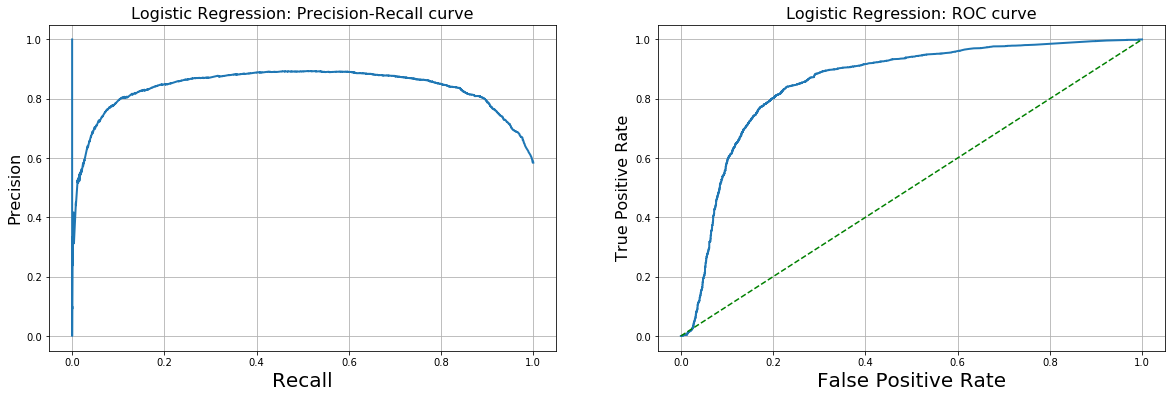

ROC-AUC score:	 0.8524225700834559
PR-AUC score:	 0.8287388078754648
accuracy score:	 0.5867240176703092


             precision    recall  f1-score   support

    nontext     0.8542    0.0114    0.0225      3589
       text     0.5852    0.9986    0.7380      5013

avg / total     0.6974    0.5867    0.4395      8602



In [8]:
# стандартные параметры
test_model(LogisticRegression(random_state=42, n_jobs=-1), 'Logistic Regression', X_train, y_train, X_test, y_test)

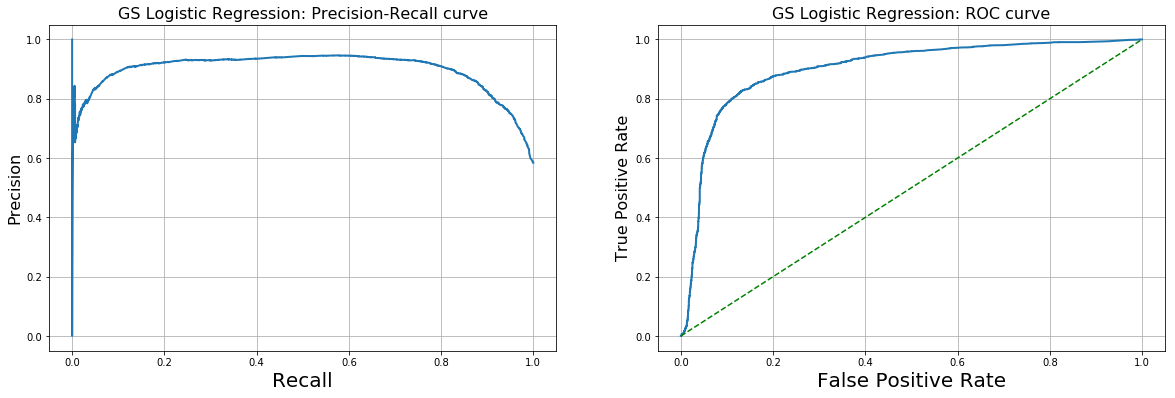

ROC-AUC score:	 0.8997837720005445
PR-AUC score:	 0.8945448521712978
accuracy score:	 0.8431760055800976


             precision    recall  f1-score   support

    nontext     0.8146    0.8080    0.8113      3589
       text     0.8633    0.8683    0.8658      5013

avg / total     0.8430    0.8432    0.8431      8602

Оптимальные параметры:  {'C': 0.01, 'penalty': 'l1'}


In [12]:
# перебор по сетке
clf = LogisticRegression(random_state=42, n_jobs=-1)
param = {'penalty': ['l1', 'l2'], 'C': np.linspace(0.01, 1, 10) }
gscv = GridSearchCV(clf, param_grid=param, scoring='roc_auc', n_jobs=-1)
test_model(gscv, 'GS Logistic Regression', X_train, y_train, X_test, y_test)
print("Оптимальные параметры: ", gscv.best_params_)

## Случайный лес

In [9]:
from sklearn.ensemble import RandomForestClassifier

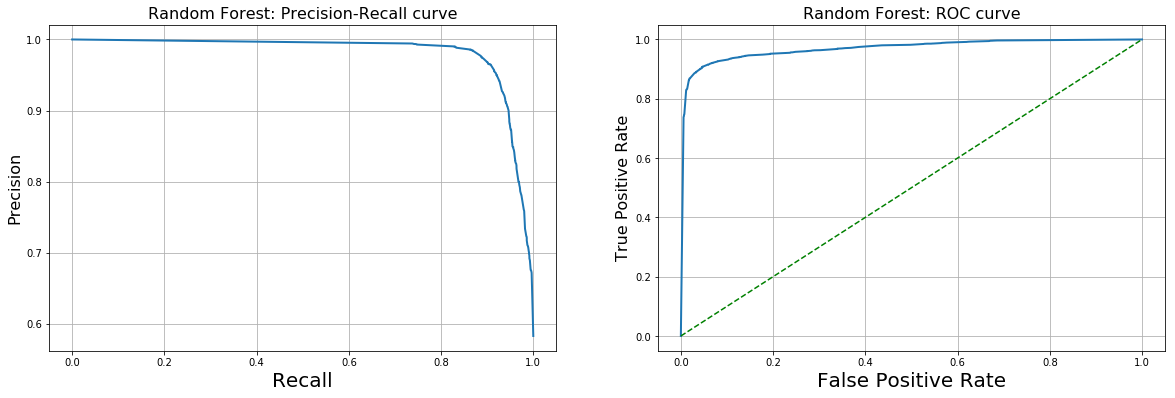

ROC-AUC score:	 0.9694517853469528
PR-AUC score:	 0.9784231918681547
accuracy score:	 0.9266449662869101


             precision    recall  f1-score   support

    nontext     0.8818    0.9518    0.9154      3589
       text     0.9634    0.9086    0.9352      5013

avg / total     0.9293    0.9266    0.9270      8602



In [11]:
# стандартные параметры
test_model(RandomForestClassifier(n_jobs=-1, random_state=42), 'Random Forest', X_train, y_train, X_test, y_test)

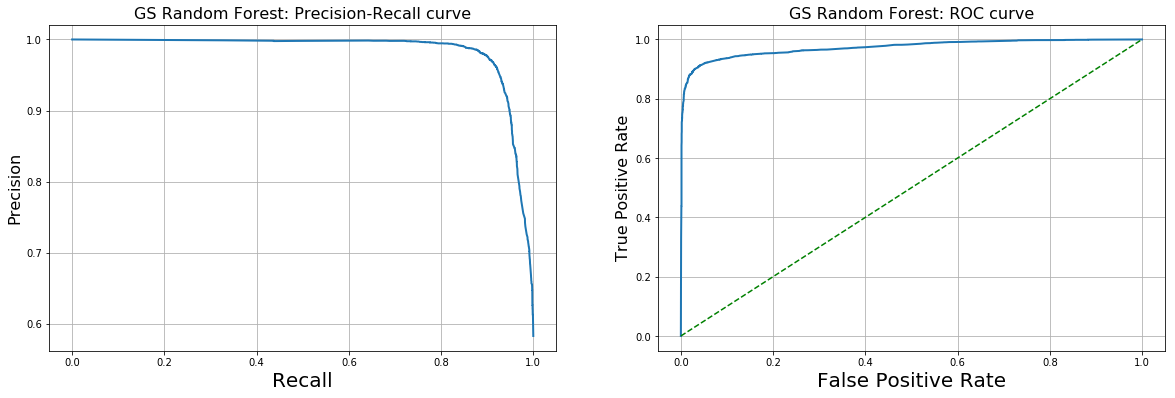

ROC-AUC score:	 0.9727359742351691
PR-AUC score:	 0.9831635027613139
accuracy score:	 0.931643803766566


             precision    recall  f1-score   support

    nontext     0.8923    0.9510    0.9207      3589
       text     0.9632    0.9178    0.9399      5013

avg / total     0.9336    0.9316    0.9319      8602

Оптимальные параметры:  {'max_depth': 50, 'n_estimators': 500}


In [13]:
# перебор по сетке
clf = RandomForestClassifier(n_jobs=-1, random_state=42)
param = {'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 20, 50, 100, 500]}
gscv = GridSearchCV(clf, param_grid=param, scoring='roc_auc', n_jobs=-1)
test_model(gscv, 'GS Random Forest', X_train, y_train, X_test, y_test)
print("Оптимальные параметры: ", gscv.best_params_)

## Градиентный бустинг

In [13]:
import xgboost as xgb

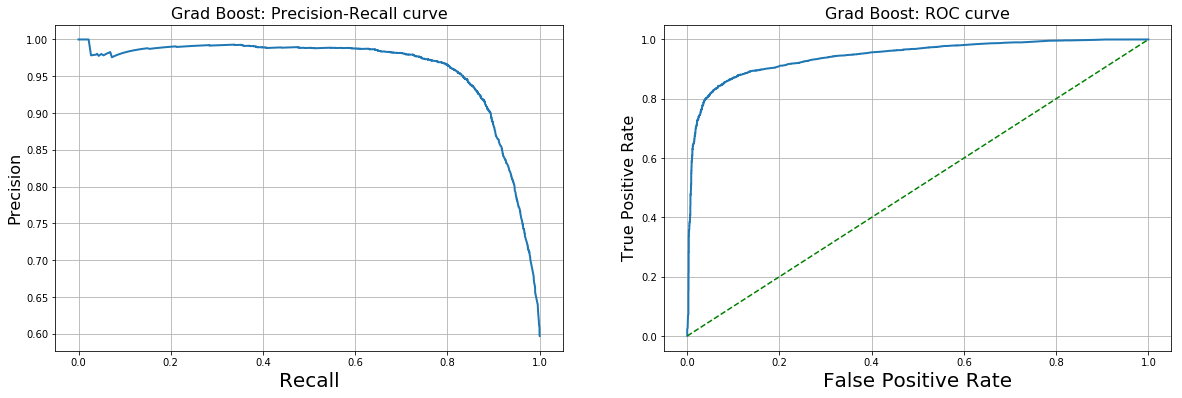

ROC-AUC score:	 0.9436720030845409
PR-AUC score:	 0.9598237003301546
accuracy score:	 0.8830504533829342


             precision    recall  f1-score   support

    nontext     0.8398    0.8894    0.8639      3589
       text     0.9173    0.8785    0.8975      5013

avg / total     0.8850    0.8831    0.8835      8602



In [14]:
# стандартные параметры
test_model(xgb.XGBClassifier(n_jobs=-1, random_state=42), 'Grad Boost', X_train, y_train, X_test, y_test)

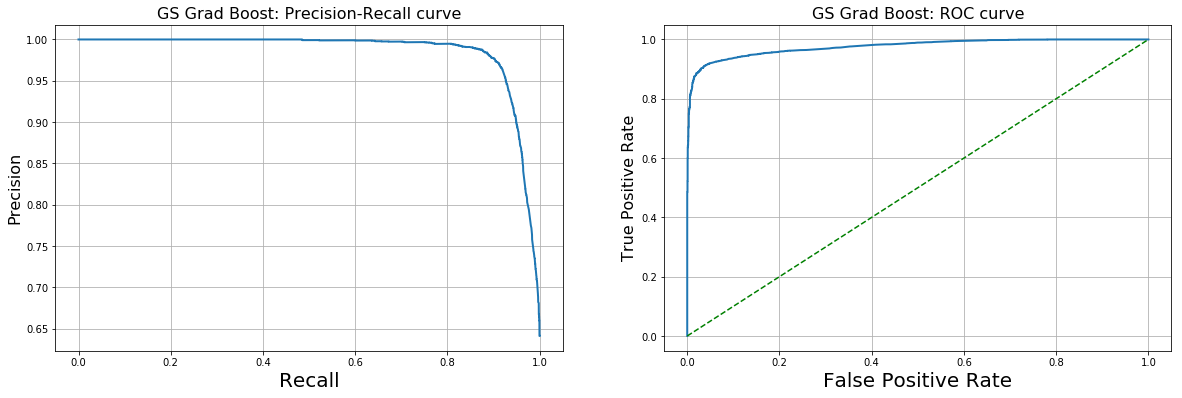

ROC-AUC score:	 0.9760032941935254
PR-AUC score:	 0.9851649731377351
accuracy score:	 0.9323413159730295


             precision    recall  f1-score   support

    nontext     0.8892    0.9571    0.9219      3589
       text     0.9675    0.9146    0.9403      5013

avg / total     0.9348    0.9323    0.9326      8602

Оптимальные параметры:  {'max_depth': 10, 'n_estimators': 500}


In [15]:
# перебор по сетке
clf = xgb.XGBClassifier(objective='binary:logistic', n_jobs=-1, random_state=42)
param = {'max_depth': [5, 10, 20, 50, 100], 'n_estimators': [10, 20, 50, 100, 500]}
gscv = GridSearchCV(clf, param_grid=param, scoring='roc_auc', n_jobs=-1)
test_model(gscv, 'GS Grad Boost', X_train, y_train, X_test, y_test)
print("Оптимальные параметры: ", gscv.best_params_)

## Вывод:

Построили 3 разных классификатора, для каждого нашли наиболее оптимальные параметры. Случайный лес и градиентный бустинг показали лучший примерно одинаковый по качеству результат на оптимальных параметрах. По построенным таблицам метрик видно, что на text объектах recall меньше, это означает, что доля правильных ответов больше на nontext объектах. В то же время на текстах больше precision, то есть предсказания классификаторов, давшие ответ text, более точные.